In [1]:
!pip install spotipy
!pip install plotly

In [35]:
import plotly.express as px

### Instruction
1. Use Spotify API to get the data-
2. Use the saved CSV to load (under the heading load data from local)

In [2]:
import pandas as pd
import util
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from xgboost import XGBRegressor


ModuleNotFoundError: No module named 'xgboost'

In [3]:
RANDOM_STATE = 1 #setting global variable to 1, to be used in random seed generator

In [4]:
pd.options.display.max_columns=100 #remove truncated view 

## Credentials

In [5]:
idcl ="xx" 
clsec = "xx"

client_credentials_manager = SpotifyClientCredentials(client_id=idcl, client_secret=clsec)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Fetch data from spotify

### Getting all the tracks

In [7]:
artist_names =['Talha Anjum'] 

# Initialize empty list to store track data
all_tracks_data = []

# Loop through each artist
for artist_name in artist_names:
    # Search for the artist
    results = sp.search(q='artist:' + artist_name, type='artist')
    if len(results['artists']['items']) > 0:
        artist = results['artists']['items'][0]
        artist_id = artist['id']

        # Check if the artist has any albums
        albums = sp.artist_albums(artist_id, album_type='album', limit=50)['items']
        if len(albums) == 0:
            # If the artist has no albums, get their top tracks instead
            top_tracks = sp.artist_top_tracks(artist_id)['tracks']

            # Loop through each top track
            for track in top_tracks:
                track_id = track['id']
                track_name = track['name']

                # Get audio features for the track
                audio_features = sp.audio_features(track_id)

                # Get track popularity
                track_popularity = track['popularity']

                track_data = {
                    'artist': artist_name,
                    'album': None,
                    'track_name': track_name,
                    'track_id': track_id,
                    'track_popularity': track_popularity
                }

                if audio_features is not None:
                    track_data.update(audio_features[0])

                all_tracks_data.append(track_data)
        else:
            # Loop through each album
            for album in albums:
                album_id = album['id']
                album_name = album['name']

                # Get all tracks from the album
                album_tracks = util.get_album_tracks(album_id)

                # Loop through each track
                for track in album_tracks:
                    track_id = track['id']
                    track_name = track['name']

                    # Get audio features for the track
                    audio_features = sp.audio_features(track_id)

                    # Get track popularity
                    track_info = sp.track(track_id)
                    track_popularity = track_info['popularity']

                    track_data = {
                        'artist': artist_name,
                        'album': album_name,
                        'track_name': track_name,
                        'track_id': track_id,
                        'track_popularity': track_popularity
                    }

                    if audio_features is not None:
                        track_data.update(audio_features[0])
                    else:
                        track_data.update({'acousticness': None, 'danceability': None, 'duration_ms': None, 'energy': None, 'instrumentalness': None, 'key': None, 'liveness': None, 'loudness': None, 'mode': None, 'speechiness': None, 'tempo': None, 'time_signature': None, 'valence': None})

                    all_tracks_data.append(track_data)

In [8]:
### Converting to dataframe

In [9]:
tracks_df = pd.DataFrame(all_tracks_data)

In [ ]:
tracks_df.to_csv('./tracks.csv',index=False)

In [ ]:
tracks_df.head()

In [ ]:
tracks_df.shape

### Load dataset from local

In [19]:
tracks_df = pd.read_csv('./all_tracks_10K.csv')

In [6]:
tracks_df.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

## EDA

In [7]:
tracks_df.head()

artist     album          track_name                track_id  \
0  Drake  Her Loss           Rich Flex  1bDbXMyjaUIooNwFE9wn0N   
1  Drake  Her Loss  Major Distribution  46s57QULU02Voy0Kup6UEb   
2  Drake  Her Loss               On BS  34tz0eDhGuFErIuW3q4mPX   
3  Drake  Her Loss     BackOutsideBoyz  0wshkEEcJUQU33RSRBb5dv   
4  Drake  Her Loss  Privileged Rappers  7l2nxyx7IkBX5orhkALg0V   

   track_popularity  danceability  energy  key  loudness  mode  speechiness  \
0                90         0.561   0.520   11    -9.342     0        0.244   
1                78         0.908   0.546    8   -10.491     0        0.323   
2                81         0.841   0.358    9    -8.368     1        0.591   
3                75         0.849   0.433    5    -8.434     0        0.316   
4                77         0.934   0.614    5    -7.384     1        0.198   

   acousticness  instrumentalness  liveness  valence    tempo            type  \
0       0.05030          0.000002    0.3550    0.424  153.150  audio_features   
1       0.01270          0.000000    0.0707    0.225  131.016  audio_features   
2       0.02010          0.000000    0.3900    0.329  158.014  audio_features   
3       0.04070          0.000000    0.3880    0.395  142.110  audio_features   
4       0.00274          0.000000    0.1230    0.616  144.045  audio_features   

                       id                                   uri  \
0  1bDbXMyjaUIooNwFE9wn0N  spotify:track:1bDbXMyjaUIooNwFE9wn0N   
1  46s57QULU02Voy0Kup6UEb  spotify:track:46s57QULU02Voy0Kup6UEb   
2  34tz0eDhGuFErIuW3q4mPX  spotify:track:34tz0eDhGuFErIuW3q4mPX   
3  0wshkEEcJUQU33RSRBb5dv  spotify:track:0wshkEEcJUQU33RSRBb5dv   
4  7l2nxyx7IkBX5orhkALg0V  spotify:track:7l2nxyx7IkBX5orhkALg0V   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/1bDbXMyjaUIo...   
1  https://api.spotify.com/v1/tracks/46s57QULU02V...   
2  https://api.spotify.com/v1/tracks/34tz0eDhGuFE...   
3  https://api.spotify.com/v1/tracks/0wshkEEcJUQU...   
4  https://api.spotify.com/v1/tracks/7l2nxyx7IkBX...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/1bDb...       239360   
1  https://api.spotify.com/v1/audio-analysis/46s5...       170502   
2  https://api.spotify.com/v1/audio-analysis/34tz...       261544   
3  https://api.spotify.com/v1/audio-analysis/0wsh...       152962   
4  https://api.spotify.com/v1/audio-analysis/7l2n...       160821   

   time_signature  
0               3  
1               4  
2               4  
3               4  
4               4

In [8]:
tracks_df.shape

print(f'There are {tracks_df.shape[0]} samples and {tracks_df.shape[1]} number of features')

There are 11492 samples and 23 number of features


In [10]:
tracks_df.describe()

track_popularity  danceability        energy           key  \
count      11492.000000  11492.000000  11492.000000  11492.000000   
mean          33.818134      0.595621      0.617767      5.281500   
std           21.539144      0.163356      0.217946      3.551973   
min            0.000000      0.000000      0.000000      0.000000   
25%           17.000000      0.501000      0.470000      2.000000   
50%           32.000000      0.616000      0.643000      5.000000   
75%           49.000000      0.710000      0.792000      8.000000   
max           94.000000      0.977000      0.998000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  11492.000000  11492.000000  11492.000000  11492.000000   
mean      -7.689886      0.587191      0.119024      0.257865   
std        4.047267      0.492360      0.141112      0.297773   
min      -60.000000      0.000000      0.000000      0.000000   
25%       -8.997000      0.000000      0.037500      0.018975   
50%       -6.784500      1.000000      0.056000      0.116000   
75%       -5.143750      1.000000      0.138250      0.436000   
max        0.497000      1.000000      0.966000      0.995000   

       instrumentalness      liveness       valence         tempo  \
count      11492.000000  11492.000000  11492.000000  11492.000000   
mean           0.132997      0.215085      0.409950    119.470999   
std            0.295937      0.185534      0.235076     29.353267   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.100000      0.218000     95.011000   
50%            0.000010      0.135000      0.390000    121.060000   
75%            0.006575      0.277000      0.580000    137.847000   
max            0.997000      0.994000      0.983000    222.083000   

        duration_ms  time_signature  
count  1.149200e+04    11492.000000  
mean   2.253046e+05        3.917160  
std    8.886225e+04        0.426387  
min    2.000000e+03        0.000000  
25%    1.864510e+05        4.000000  
50%    2.218760e+05        4.000000  
75%    2.574965e+05        4.000000  
max    4.541734e+06        5.000000

In [15]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11492 entries, 0 to 11491
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            11492 non-null  object 
 1   album             11486 non-null  object 
 2   track_name        11492 non-null  object 
 3   track_id          11492 non-null  object 
 4   track_popularity  11492 non-null  int64  
 5   danceability      11492 non-null  float64
 6   energy            11492 non-null  float64
 7   key               11492 non-null  int64  
 8   loudness          11492 non-null  float64
 9   mode              11492 non-null  int64  
 10  speechiness       11492 non-null  float64
 11  acousticness      11492 non-null  float64
 12  instrumentalness  11492 non-null  float64
 13  liveness          11492 non-null  float64
 14  valence           11492 non-null  float64
 15  tempo             11492 non-null  float64
 16  type              11492 non-null  object

In [16]:
tracks_df.isnull().sum()

artist              0
album               6
track_name          0
track_id            0
track_popularity    0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

In [17]:
# Duplicated data

In [19]:
tracks_df[tracks_df.duplicated(subset=['track_name'])].shape

(6514, 23)

In [18]:
tracks_df[tracks_df['track_name']=='2step']

artist   album track_name                track_id  track_popularity  \
688   Ed Sheeran  #NAME?      2step  6t0Hx7pDeLY6ibIwBpG8Wd                22   
706   Ed Sheeran  #NAME?      2step  1v5KcxVewoGUgpyzl3c1w7                20   
730   Ed Sheeran  #NAME?      2step  55XROTmSsfqdnpi8jqvFpZ                30   
754   Ed Sheeran  #NAME?      2step  1XWSfcOq25pnWNDkxK6KRK                22   
778   Ed Sheeran  #NAME?      2step  6d9XYGdPLR5IqnGA0zPZ6I                20   
802   Ed Sheeran  #NAME?      2step  3sXCyRntUKNsaeKNyFWOE3                 7   
826   Ed Sheeran  #NAME?      2step  5X7ipJI2SGHsTmT2u5zRXi                10   
850   Ed Sheeran  #NAME?      2step  4eIV00OcaflqkzcnTUyMa3                27   
874   Ed Sheeran  #NAME?      2step  5aMl6UJ6Md3Kdh33x5kT9V                31   
898   Ed Sheeran  #NAME?      2step  3Txgac2b3RcUiocoPk6u6u                11   
922   Ed Sheeran  #NAME?      2step  4T2sTuHeEIroGc27fVqL8t                24   
946   Ed Sheeran  #NAME?      2step  4LQgUCaHbUe1YRczQByShv                25   
970   Ed Sheeran  #NAME?      2step  0Kyf0mywQUx3aqtYVtiR6U                42   
1020  Ed Sheeran       =      2step  2SUxn2O9NHL6GHGQFgwCY0                74   
1034  Ed Sheeran  #NAME?      2step  3Oj1LNWn6826ugw1fHzUYv                45   

      danceability  energy  key  loudness  mode  speechiness  acousticness  \
688          0.763   0.661    4    -5.592     0        0.056         0.169   
706          0.763   0.661    4    -5.592     0        0.056         0.169   
730          0.763   0.661    4    -5.592     0        0.056         0.169   
754          0.763   0.661    4    -5.592     0        0.056         0.169   
778          0.763   0.661    4    -5.592     0        0.056         0.169   
802          0.763   0.661    4    -5.592     0        0.056         0.169   
826          0.763   0.661    4    -5.592     0        0.056         0.169   
850          0.763   0.661    4    -5.592     0        0.056         0.169   
874          0.763   0.661    4    -5.592     0        0.056         0.169   
898          0.763   0.661    4    -5.592     0        0.056         0.169   
922          0.763   0.661    4    -5.592     0        0.056         0.169   
946          0.763   0.661    4    -5.592     0        0.056         0.169   
970          0.763   0.661    4    -5.592     0        0.056         0.169   
1020         0.763   0.661    4    -5.592     0        0.056         0.169   
1034         0.763   0.661    4    -5.592     0        0.056         0.169   

      instrumentalness  liveness  valence   tempo            type  \
688                0.0     0.117    0.632  95.002  audio_features   
706                0.0     0.117    0.632  95.002  audio_features   
730                0.0     0.117    0.632  95.002  audio_features   
754                0.0     0.117    0.632  95.002  audio_features   
778                0.0     0.117    0.632  95.002  audio_features   
802                0.0     0.117    0.632  95.002  audio_features   
826                0.0     0.117    0.632  95.002  audio_features   
850                0.0     0.117    0.632  95.002  audio_features   
874                0.0     0.117    0.632  95.002  audio_features   
898                0.0     0.117    0.632  95.002  audio_features   
922                0.0     0.117    0.632  95.002  audio_features   
946                0.0     0.117    0.632  95.002  audio_features   
970                0.0     0.117    0.632  95.002  audio_features   
1020               0.0     0.117    0.632  95.002  audio_features   
1034               0.0     0.117    0.632  95.002  audio_features   

                          id                                   uri  \
688   6t0Hx7pDeLY6ibIwBpG8Wd  spotify:track:6t0Hx7pDeLY6ibIwBpG8Wd   
706   1v5KcxVewoGUgpyzl3c1w7  spotify:track:1v5KcxVewoGUgpyzl3c1w7   
730   55XROTmSsfqdnpi8jqvFpZ  spotify:track:55XROTmSsfqdnpi8jqvFpZ   
754   1XWSfcOq25pnWNDkxK6KRK  spotify:track:1XWSfcOq25pnWNDkxK6KRK   
778   6d9

## Visualizations

### Distribution of features


In [22]:
num_df = tracks_df.select_dtypes(include = 'number')

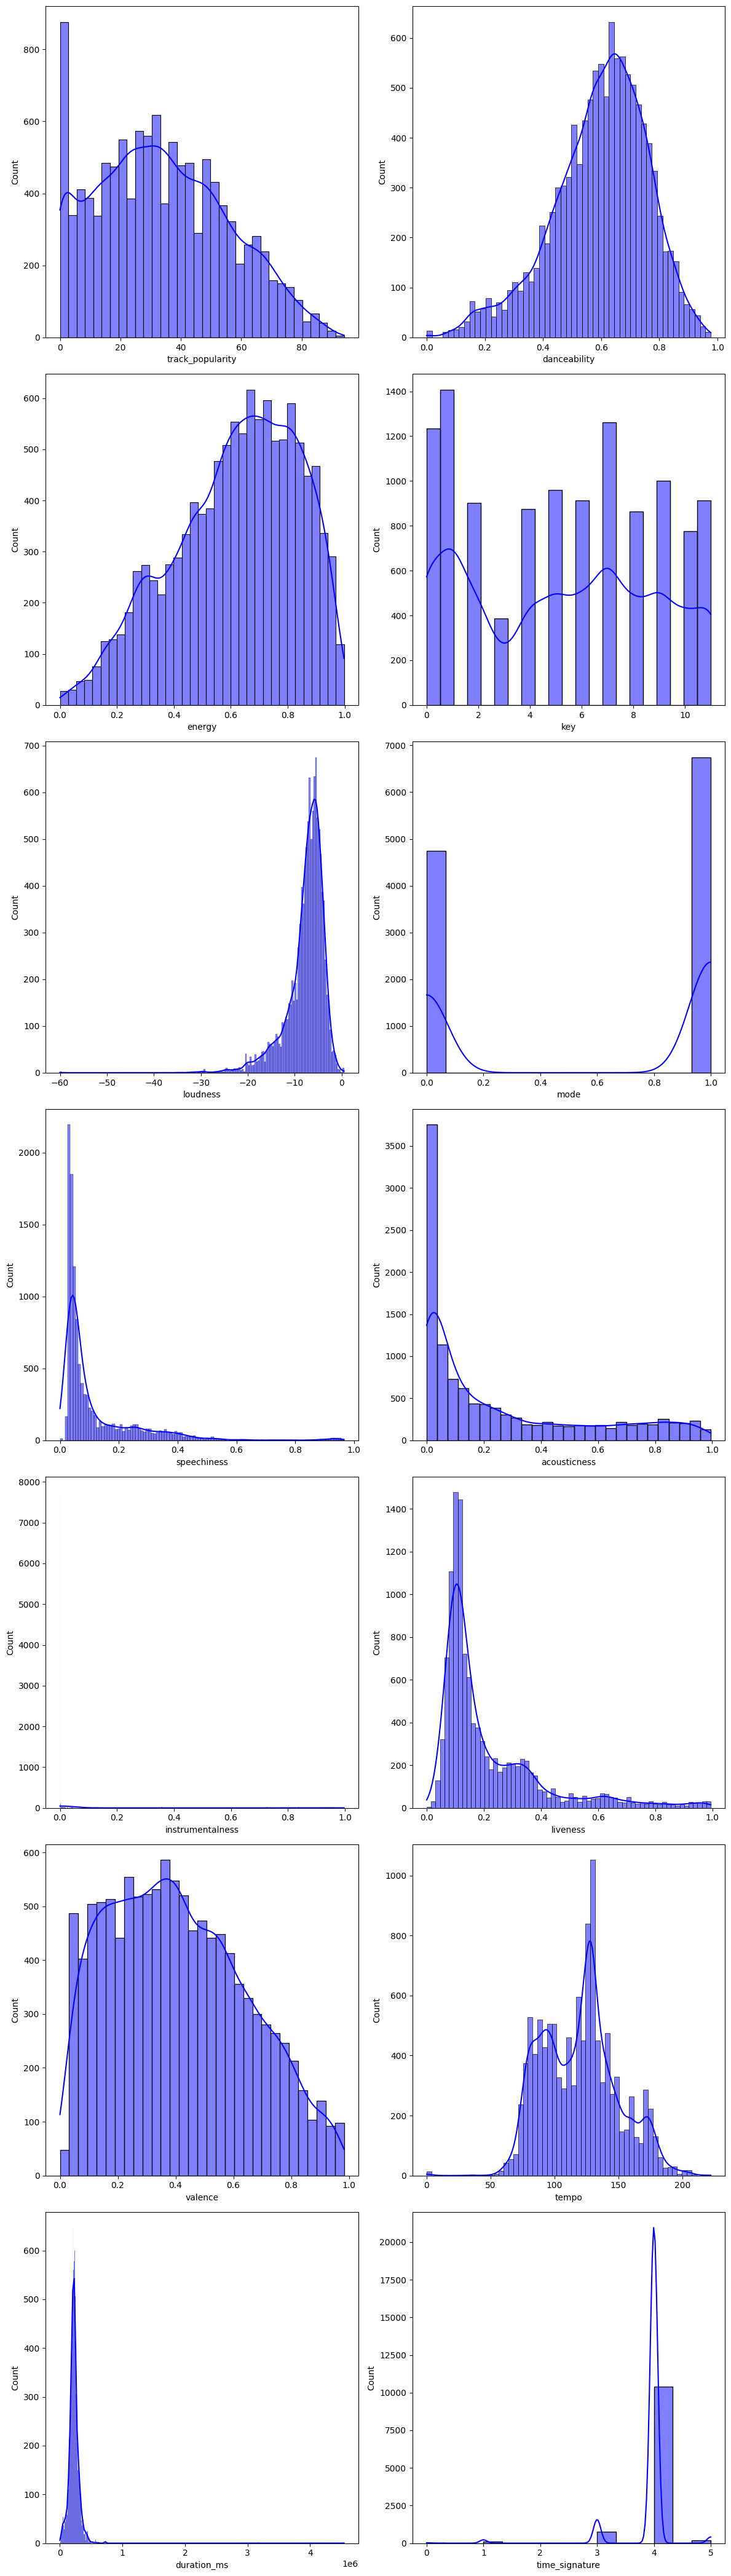

In [23]:
num_features = list(num_df.columns)
plot_per_row = 2
num_plots = len(num_features)

num_rows = (num_plots + plot_per_row - 1) // plot_per_row

fig, axes = plt.subplots(num_rows, plot_per_row, figsize=(12, 6*num_rows), squeeze=False)

for i, feature in enumerate(num_features):
    row = i // plot_per_row
    col = i % plot_per_row
    ax = axes[row, col]
    sns.histplot(data=num_df, x=feature, kde=True, ax=ax, color='blue')

plt.tight_layout()
plt.show()

### Boxplots

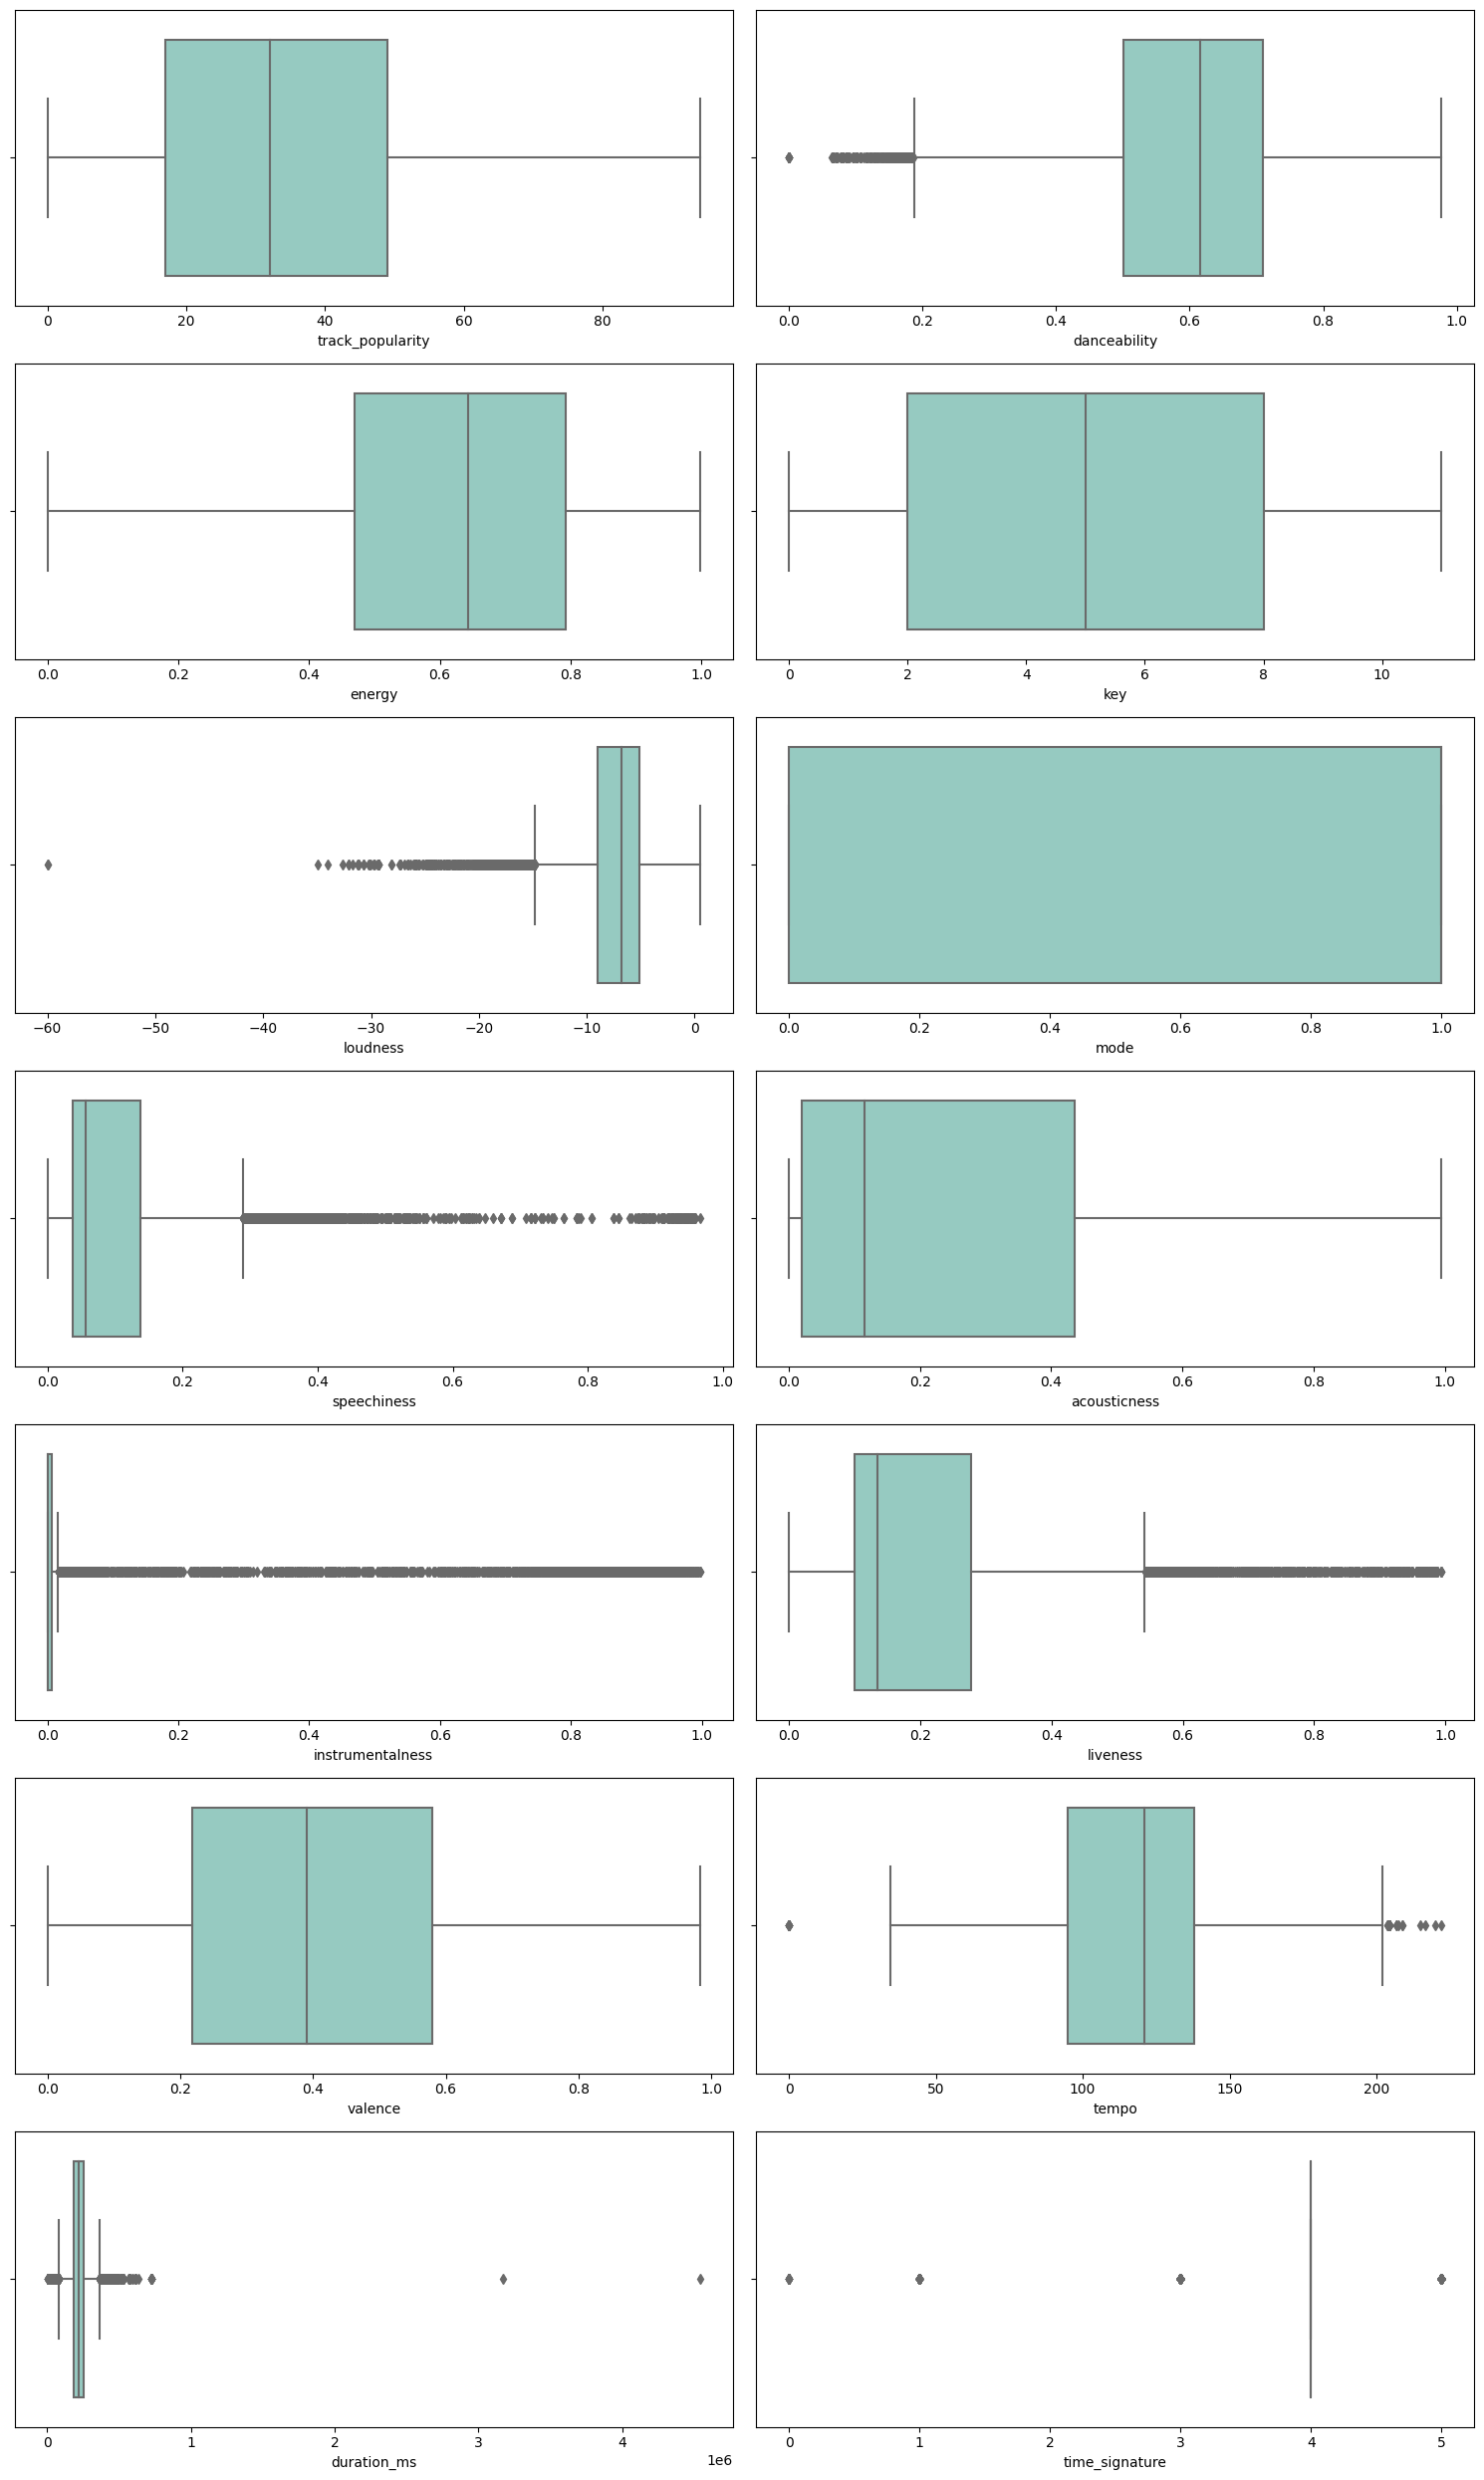

In [24]:
names = list(tracks_df.select_dtypes(include='number').columns)

plot_per_row = 2

f, axes = plt.subplots(round(len(names)/plot_per_row), plot_per_row, figsize = (15, 25))

y = 0;

for name in names:
    i, j = divmod(y, plot_per_row)
    sns.boxplot(x=tracks_df[name], ax=axes[i, j], palette = 'Set3')
    y = y + 1

plt.tight_layout()
plt.show()

## Data cleaning

In [41]:
tracks_df.shape

(10836, 24)

### Dropping the outliers 


In [26]:
tracks_df = tracks_df[tracks_df['loudness'] >= -25]

In [27]:
tracks_df = tracks_df[tracks_df['tempo'] >= 20]

In [28]:
tracks_df = tracks_df[tracks_df['track_popularity'] >= 1]

In [42]:
tracks_df.shape

(10836, 24)

### Most popular artist

In [29]:
#Find the most popular artists in data set

plt.figure(figsize = (20, 14))

def visualize_word_counts(counts):
    wc = WordCloud(max_font_size=130, min_font_size=25, colormap='tab20', background_color='white', prefer_horizontal=.95, width=2100, height=700, random_state=0)
    cloud = wc.generate_from_frequencies(counts)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

<Figure size 2000x1400 with 0 Axes>

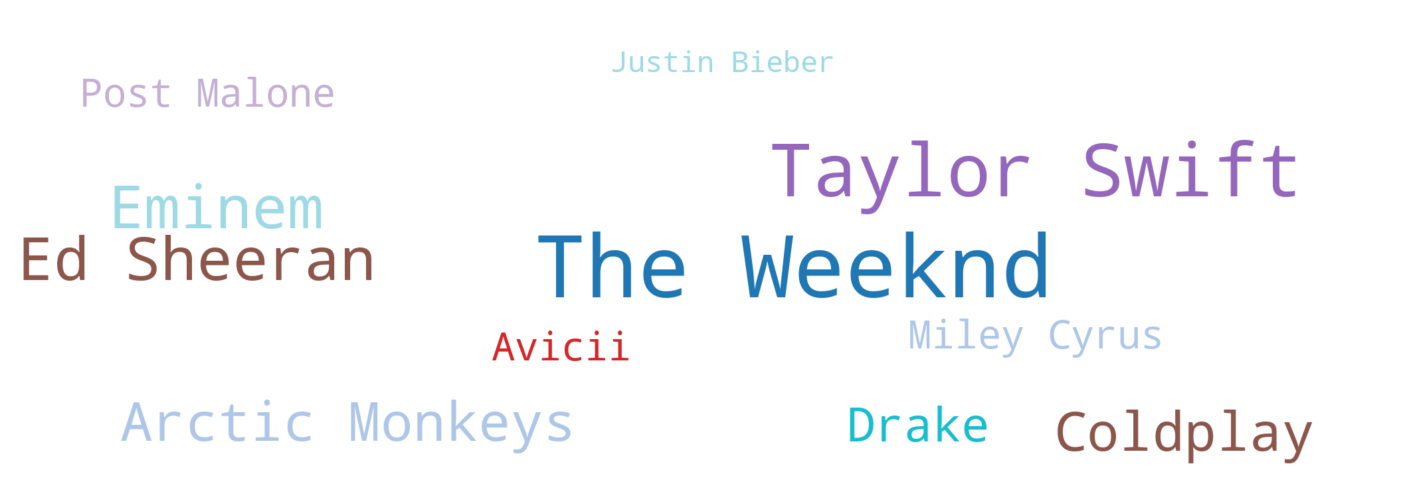

In [30]:
most_popularity = tracks_df.query('track_popularity > 86', inplace = False).sort_values('track_popularity', ascending = False)

lead_artists = most_popularity['artist'].value_counts().head(15)

visualize_word_counts(lead_artists)

### Comparing top 100 popular songs with remaining list

In [31]:
numeric_only_df = tracks_df[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence','track_popularity']]
                      
                      

In [32]:
sorted_df_all = numeric_only_df.sort_values(by = ['track_popularity'],ascending=False)

In [33]:
sorted_df_100 = numeric_only_df.sort_values(by = ['track_popularity'],ascending=False)[:100]

In [34]:
features_all = sorted_df_all.mean(numeric_only=True).tolist()

In [35]:
features = sorted_df_100.mean(numeric_only=True).tolist()

In [36]:
labels = list(sorted_df_all)
labels.pop()
features_all.pop()
features.pop()

86.94

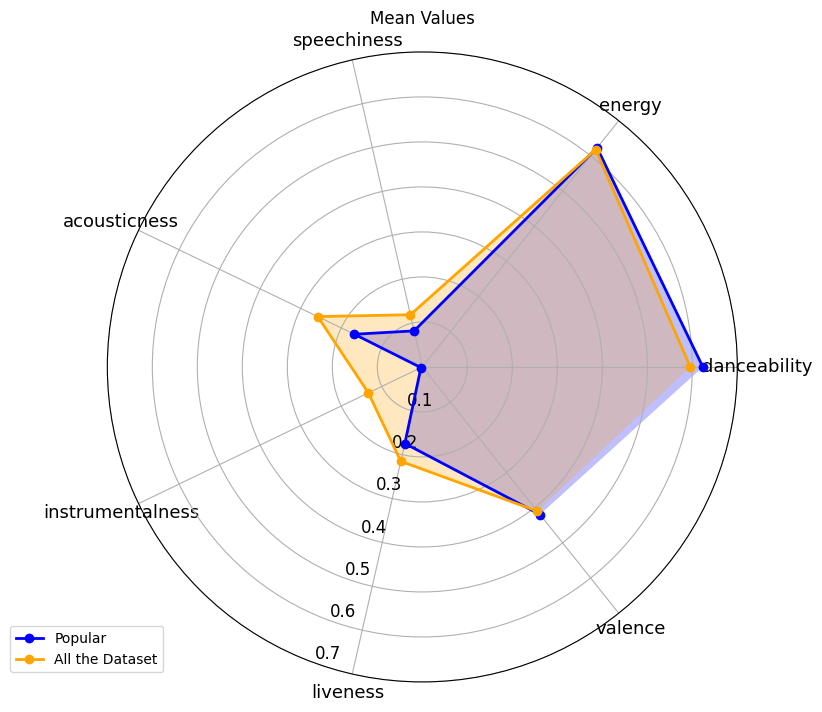

In [37]:
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
fig = plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, features, 'o-', linewidth=2, label = "Popular", color= 'blue')
ax.fill(angles, features, alpha=0.25, facecolor='blue')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)


ax.set_rlabel_position(250)
plt.yticks([0.1 , 0.2 , 0.3 , 0.4, 0.5,  0.6, 0.7], ["0.1",'0.2', "0.3", "0.4", "0.5", "0.6", '0.7'  ], size=12)
plt.ylim(0,0.7)

ax.plot(angles, features_all, 'o-', linewidth=2, label = "All the Dataset", color= 'orange')
ax.fill(angles, features_all, alpha=0.25, facecolor='orange')
ax.set_title('Mean Values')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

### Correlation

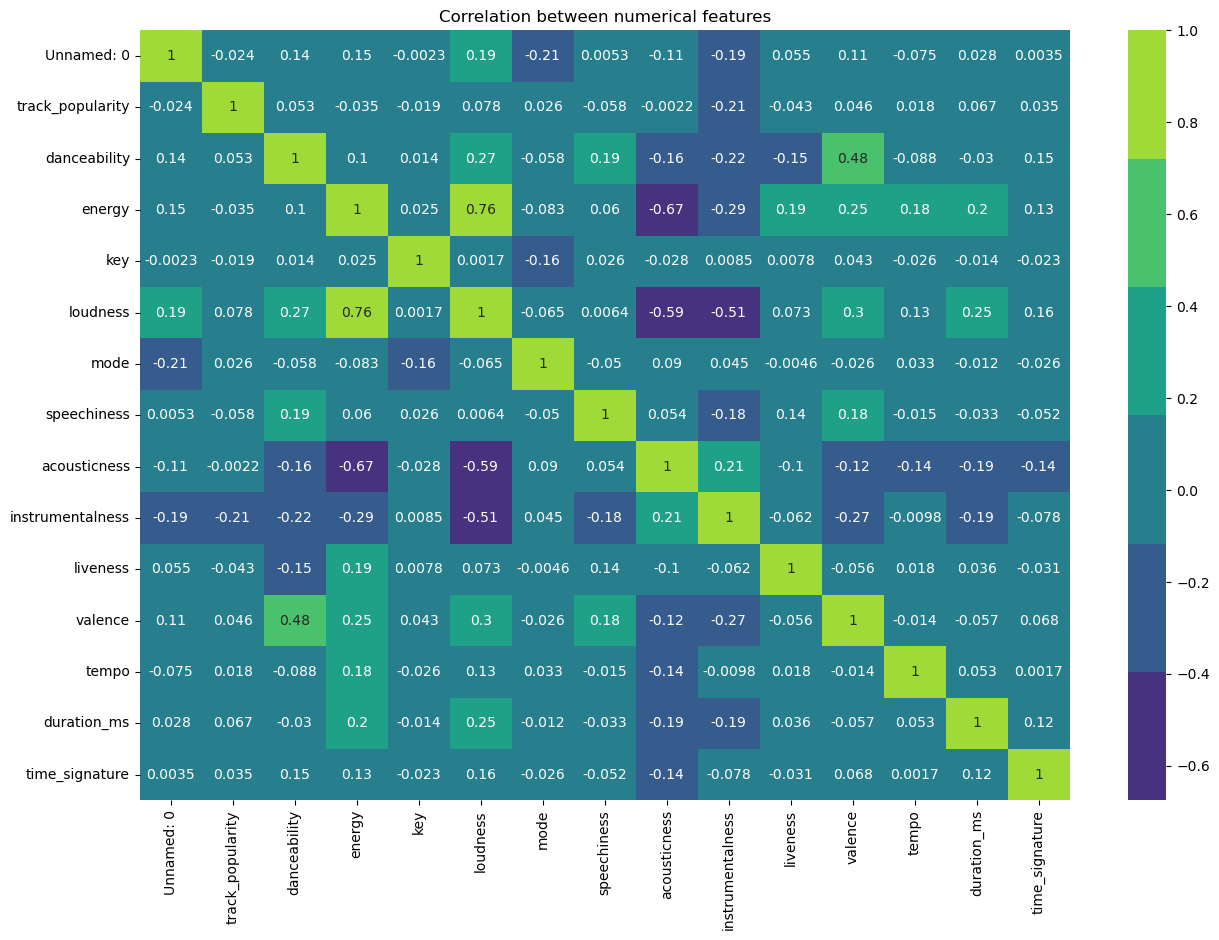

In [31]:
plt.figure(figsize = (15, 10))

corr_matrix = tracks_df.corr()
cmap = sns.color_palette('viridis')
sns.heatmap(corr_matrix, annot = True, cmap = cmap)
plt.title('Correlation between numerical features')
plt.show()

In [32]:
corr_matrix["track_popularity"].sort_values(ascending=False)

track_popularity    1.000000
loudness            0.077909
duration_ms         0.067015
danceability        0.052613
valence             0.046300
time_signature      0.034940
mode                0.025886
tempo               0.017832
acousticness       -0.002221
key                -0.019299
Unnamed: 0         -0.024257
energy             -0.035439
liveness           -0.042800
speechiness        -0.057602
instrumentalness   -0.211017
Name: track_popularity, dtype: float64

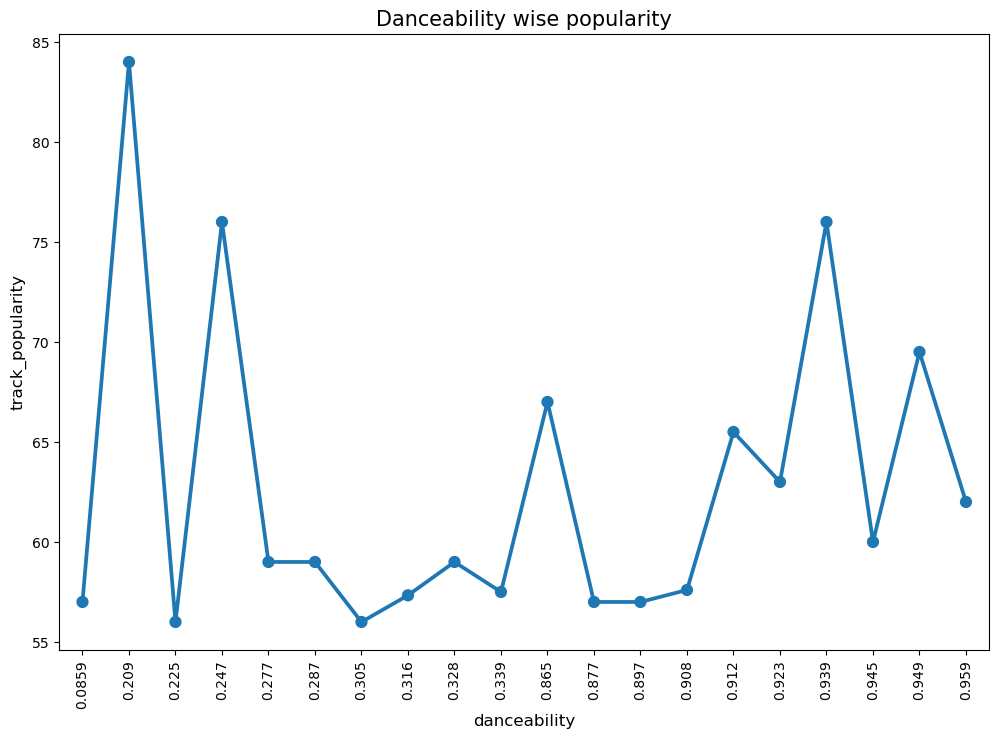

In [37]:
#Bivariate analysis

x = tracks_df.groupby("danceability")["track_popularity"].mean().sort_values(ascending=False).head(20).reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=x["danceability"].values, y=x['track_popularity'].values)
plt.ylabel('track_popularity', fontsize=12)
plt.xlabel('danceability', fontsize=12)
plt.title("Danceability wise popularity", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

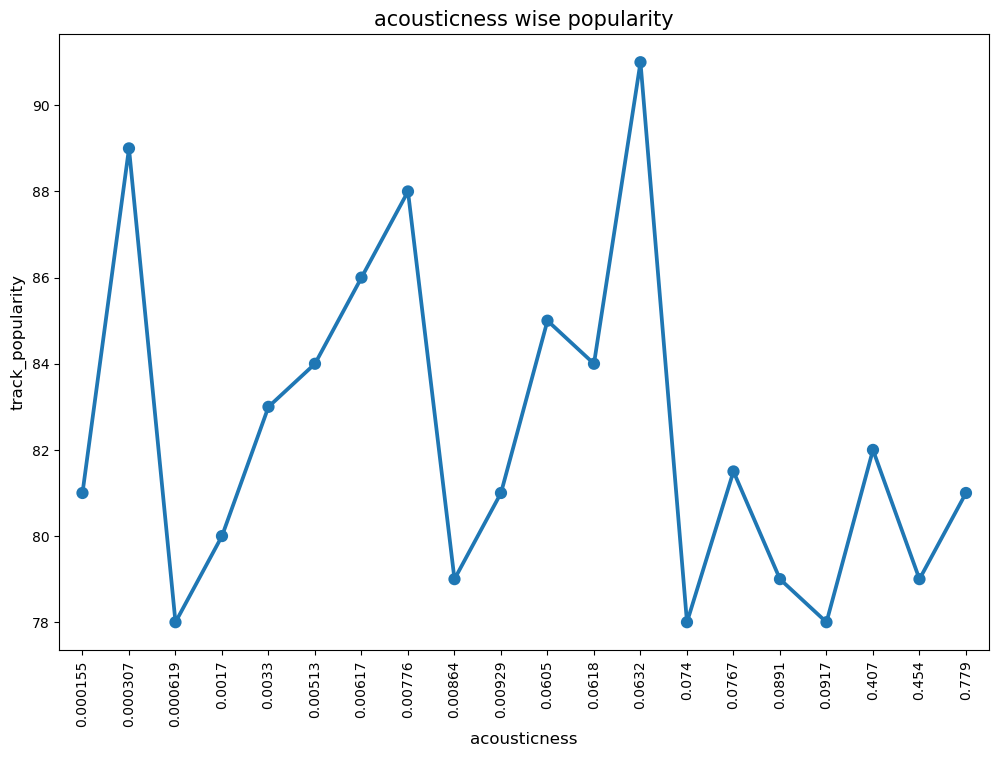

In [38]:
#Bivariate analysis

x = tracks_df.groupby("acousticness")["track_popularity"].mean().sort_values(ascending=False).head(20).reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=x["acousticness"].values, y=x['track_popularity'].values)
plt.ylabel('track_popularity', fontsize=12)
plt.xlabel('acousticness', fontsize=12)
plt.title("acousticness wise popularity", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

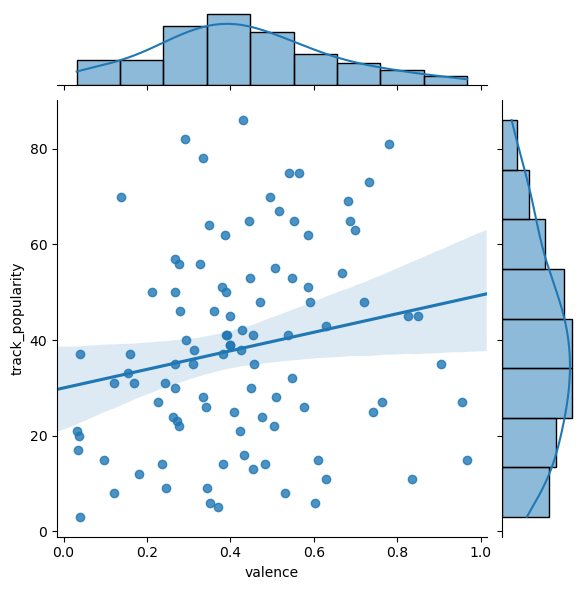

In [39]:
val_pop = sns.jointplot(x="valence", y="track_popularity", data=tracks_df.sample(100),
                  kind="reg", truncate=False)

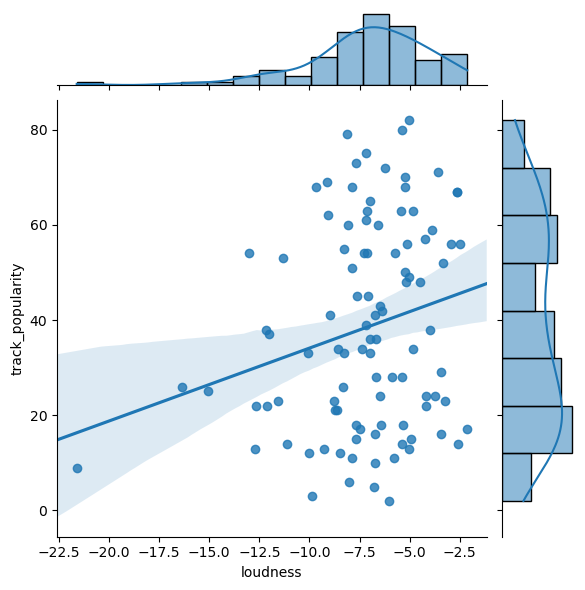

In [40]:
lfs_pop = sns.jointplot(x="loudness", y="track_popularity", data=tracks_df.sample(100),
                  kind="reg", truncate=False)

In [36]:
px.box(data_frame=tracks_df,y='track_popularity',color='key')

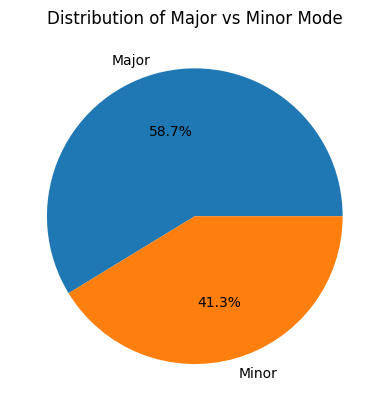

In [38]:
mode_counts = tracks_df['mode'].value_counts()

# Extract the values and labels for the pie chart
values = mode_counts.values
labels = ['Major', 'Minor']

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Distribution of Major vs Minor Mode')

# Display the chart
plt.show()

### Dropping irrelavant features

In [41]:
to_drop = ['artist','album','track_name','track_id','type','id','uri','track_href','analysis_url']

In [42]:
tracks_modified =tracks_df.drop(labels = to_drop,axis =1)

In [43]:
tracks_modified.head()

track_popularity  danceability  energy  key  loudness  mode  speechiness  \
0                90         0.561   0.520   11    -9.342     0        0.244   
1                78         0.908   0.546    8   -10.491     0        0.323   
2                81         0.841   0.358    9    -8.368     1        0.591   
3                75         0.849   0.433    5    -8.434     0        0.316   
4                77         0.934   0.614    5    -7.384     1        0.198   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  \
0       0.05030          0.000002    0.3550    0.424  153.150       239360   
1       0.01270          0.000000    0.0707    0.225  131.016       170502   
2       0.02010          0.000000    0.3900    0.329  158.014       261544   
3       0.04070          0.000000    0.3880    0.395  142.110       152962   
4       0.00274          0.000000    0.1230    0.616  144.045       160821   

   time_signature  
0               3  
1               4  
2               4  
3               4  
4               4

In [24]:
tracks_df.shape

(10836, 24)

## Train test split

In [46]:
y = tracks_modified['track_popularity']   #target feature/what we want to predict

In [47]:
X = tracks_modified.drop(['track_popularity'],axis=1)

In [48]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=RANDOM_STATE)

In [49]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((8583, 13), (2862, 13), (8583,), (2862,))

## Predictive Models

### Random Forest Regressor

In [50]:
rf = RandomForestRegressor(n_estimators=200,random_state=RANDOM_STATE)

In [51]:
util.train_predict(rf,X_train,y_train,X_test,y_test)

The mean squared error is 19.74715675904801


### XGBRegressor

In [52]:
xgb = XGBRegressor(n_estimators=200,random_state=RANDOM_STATE)

In [53]:
util.train_predict(xgb,X_train,y_train,X_test,y_test)

The mean squared error is 20.249077535196456


## Feature Importance

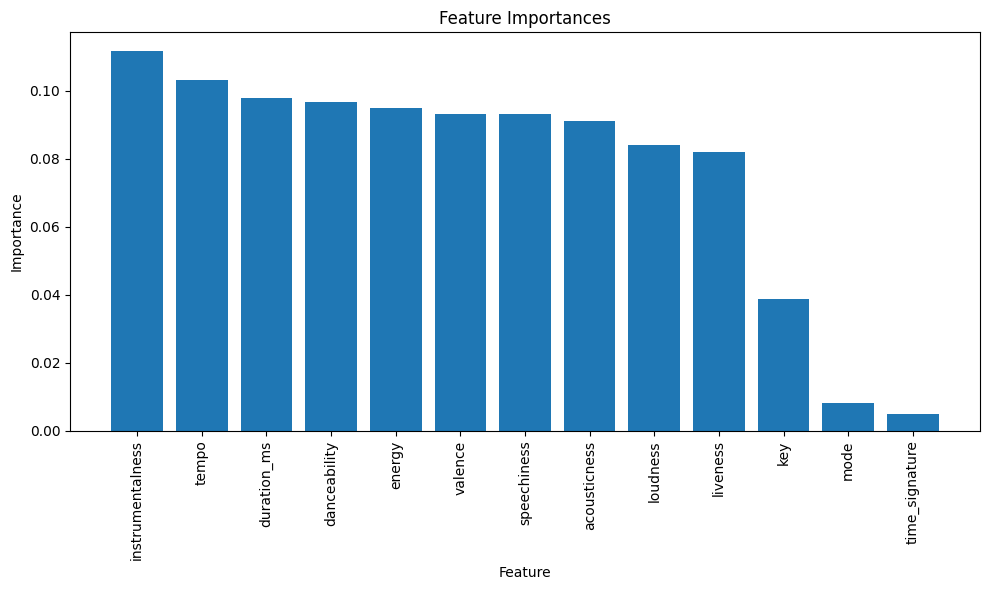

In [54]:
util.plot_feature_importance(rf)

The most important features are instrumentalness for both the models

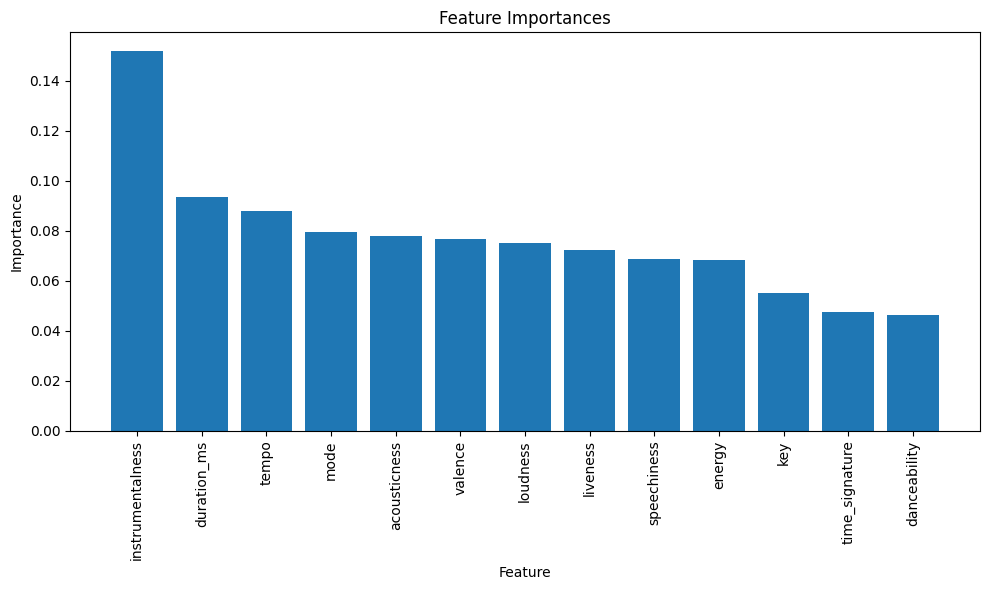

In [55]:
util.plot_feature_importance(xgb)